<a href="https://colab.research.google.com/github/mbajdman/Data-Science-Portfolio/blob/main/DoorDash_Fraudulent_User.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DoorDash Fraudulent User Detection

In [ ]:
import re
from tqdm import tqdm
from IPython.display import display
from datetime import datetime, timedelta

# Data mnunging
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt

# Feature Engineering
from multiprocessing import Pool

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Modeling
import xgboost as xgb
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, precision_recall_curve

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for consistent result
SEED = 123
np.random.seed(SEED)

#Step 1 - Problem Definition

Detect fraudulent consumer accounts e.g. accounts that should be deactivated to protect the business. We consider the account ot be fraudulent due to takeovers (by hackers) and payment fraud.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load data
users_path = '/content/drive/MyDrive/Colab Notebooks/DoorDash Fraud/doordash_data_history.csv'
df_users = pd.read_csv(users_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Step 2 - Exploratory Data Analysis

1. Create visualisations like tables and charts to gain insights.
2. Identify any data quality issues, such as missing values or inconsistencies.
3. Discover patterns and trends that can inform feature engineering and model selection.

## Overview

In [ ]:
# Create an exploratory dataset
df_eda = df_users.copy()

# Let's do an overview
df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
consumer_id,16485.0,10331.000667,5960.459638,1.000000,5160.000000,10350.000000,15465.000000,20651.000000
is_fraudulent,16485.0,0.065757,0.247864,0.000000,0.000000,0.000000,0.000000,1.000000
email_address_age_days,14426.0,439.519107,431.582203,0.000000,124.043953,281.185836,675.078291,3872.999039
email_domain_label,14426.0,508.775475,293.949005,0.000000,386.000000,386.000000,575.000000,1128.000000
email_domain_tld_label,14426.0,19.223901,7.540011,0.000000,17.000000,17.000000,17.000000,64.000000
email_username_length,14426.0,11.233537,3.349955,1.000000,9.000000,11.000000,13.000000,31.000000
latest_order_amount_usd,13273.0,113.704311,113.618403,0.011521,72.636183,109.667419,111.192081,2985.892208
latest_item_quantity,14427.0,1.141540,0.783290,1.000000,1.000000,1.000000,1.000000,30.000000
latest_item_tag_count,14427.0,0.960075,0.195790,0.000000,1.000000,1.000000,1.000000,1.000000
latest_delivery_address_name_length,14211.0,12.990571,3.127377,1.000000,11.000000,13.000000,15.000000,82.000000


We have fraud ratio of 6,5% and we can clearly say this is a imbalanced dataset.



## EDA Utility

The `df_overview` gives us idea of data type, missingness & uniqueness of the values

In [ ]:
def df_overview(df=pd.DataFrame) -> pd.DataFrame:
    """
    Provides an overview of the columns in the dataframe

    Args:
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        pd.DataFrame: A DataFrame containing the overview of the columns.
    """

    overview = pd.concat([
        df.dtypes,
        df.isna().mean(),
        df.nunique()
    ], axis=1)
    overview.columns = ['datatype', 'missingness','nunique']

    return overview

def eda_categorical(df=pd.DataFrame, feature=str, target=str, sorted_on='count', ascending=False, filter=10, fill_na=True) -> pd.DataFrame:
    """
    Performs exploratory data analysis (EDA) for categorical features.

    This function calculates the frequency of each category in the 'feature' column
    and the average value of the 'target' column for each category. It then sorts
    the results based on the 'sorted_on' parameter.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the categorical feature column.
        target (str): The name of the target column (usually a numerical or binary column).
        sorted_on (str, optional): The column to sort the results by ('count' or 'target').
                                    Defaults to 'count'.
        ascending (bool, optional): Whether to sort in ascending order. Defaults to False.
        filter (int, optional): The maximum number of rows to return. Defaults to 10.
        fill_na (bool, optional): Whether to fill missing values in the 'feature' column.
                                  Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the frequency of each category and the
                      average target value for each category, sorted according to
                      the specified parameters.
    """

    # Check that sorted_on is 'feature' or 'target'
    if sorted_on not in ['count', 'target', 'feature']:
        raise ValueError("sorted_on must be 'count', 'target', 'feature'")

    if sorted_on == 'feature':
        sorted_on = feature
    if sorted_on == 'target':
        sorted_on = target

    # Fill na is 'MISSING'
    if fill_na == True:
        df[feature] = df[feature].fillna('MISSING')

    # Get the count of is_fraud and not is_fraud by country
    table = pd.concat([
        df[feature].value_counts(),
        df.groupby(feature)[target].mean().round(3)
    ], axis=1)

    return table.sort_values(by=sorted_on, ascending=ascending).head(filter)


def eda_continuous(df=pd.DataFrame, feature=str, target=str, range=(0.1, 1.0, 0.1)) -> pd.DataFrame:
    """
    Performs exploratory data analysis (EDA) for continuous features.

    This function groups the DataFrame by the 'target' column and calculates
    descriptive statistics for the 'feature' column within each group.
    It uses the specified percentiles to provide a more detailed view
    of the distribution of the continuous feature.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the continuous feature column.
        target (str): The name of the target column (usually a categorical or binary column).
        range (tuple, optional): A tuple specifying the start, stop, and step
                                  for generating percentiles. Defaults to (0.1, 1.0, 0.1).

    Returns:
        pd.DataFrame: A DataFrame containing descriptive statistics for the
                      'feature' column within each group of the 'target' column.
    """

    # Group the DataFrame by the target column and calculate descriptive statistics
    # for the specified feature, using the given percentiles.
    table = (
        df
            .groupby(target)[feature]
            .describe(percentiles=np.arange(0.1, 1.0, 0.1))
    )

    # Return the resulting DataFrame.
    return table

## Missingness & Datatypes

In [ ]:
# What percentage of the records are missing per each fieldf
df_overview(df=df_eda)

,datatype,missingness,nunique
consumer_id,int64,0.000000,16485
is_fraudulent,int64,0.000000,2
email_address_age_days,float64,0.124901,14372
email_domain_label,float64,0.124901,946
email_domain_tld_label,float64,0.124901,58
email_username_length,float64,0.124901,29
latest_order_amount_usd,float64,0.194844,8146
latest_item_category,object,0.124841,3668
latest_item_product_title,object,0.124841,8310
latest_item_quantity,float64,0.124841,15


## Continuous Variables

In [ ]:
# Get columns that are numeric
for col in df_eda.select_dtypes(include='number').columns:
    if col not in ['consumer_id', 'is_fraudulent']:
        print(f'\n\nColumn Analysis: {col}')
        display(eda_continuous(df=df_eda, feature=col, target='is_fraudulent'))



Column Analysis: email_address_age_days


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13342.0,469.445739,430.816087,0.000000,70.632257,125.038350,168.073381,225.175187,313.315241,441.104367,615.955491,805.069231,1072.745476,3872.999039
1,1084.0,71.178588,218.496310,0.000198,0.023399,0.266408,1.941513,5.169864,10.909348,15.701640,22.027663,29.826911,151.674613,2108.044972




Column Analysis: email_domain_label


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13342.0,506.763154,288.626252,0.0,319.0,386.0,386.0,386.0,386.0,386.0,458.0,730.0,1100.0,1128.0
1,1084.0,533.543358,352.165548,2.0,64.0,386.0,386.0,386.0,386.0,395.0,578.0,1100.0,1100.0,1127.0




Column Analysis: email_domain_tld_label


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13342.0,19.187378,7.441688,0.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,64.0
1,1084.0,19.673432,8.650514,3.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,18.4,58.0




Column Analysis: email_username_length


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13342.0,11.239544,3.340242,1.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,16.0,31.0
1,1084.0,11.159594,3.468016,1.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,25.0




Column Analysis: latest_order_amount_usd


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,12208.0,106.515037,75.374026,0.012711,27.428055,56.471510,86.432630,109.667419,109.667419,109.667419,109.667419,124.781009,176.046334,2483.574474
1,1065.0,196.114314,297.412641,0.011521,38.666670,71.258411,109.667419,109.667419,109.667419,109.667419,144.093478,201.425137,404.130024,2985.892208




Column Analysis: latest_item_quantity


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13704.0,1.111062,0.668456,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0
1,723.0,1.719225,1.851107,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,14.0




Column Analysis: latest_item_tag_count


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13704.0,0.959209,0.197813,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,723.0,0.976487,0.151631,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




Column Analysis: latest_delivery_address_name_length


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13131.0,13.113624,3.109508,1.0,10.0,11.0,12.0,13.0,13.0,14.0,14.0,15.0,16.0,82.0
1,1080.0,11.494444,2.953135,3.0,7.0,9.0,10.0,11.0,12.0,12.0,13.0,14.0,15.0,21.0




Column Analysis: latest_delivery_address_region_label


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13131.0,21.067702,15.138505,0.0,5.0,5.0,6.0,10.0,18.0,27.0,33.0,38.0,43.0,48.0
1,1080.0,22.076852,15.338039,0.0,5.0,5.0,5.0,10.0,22.0,33.0,33.0,36.0,44.0,47.0




Column Analysis: latest_delivery_address_fraction_vowels


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,13131.0,0.34843,0.112959,0.000918,0.203560,0.255519,0.292286,0.322321,0.350186,0.377900,0.408851,0.443425,0.489630,0.765000
1,1080.0,0.32087,0.121761,0.012045,0.155298,0.222552,0.264000,0.293310,0.324516,0.354108,0.383136,0.420792,0.474175,0.746218




Column Analysis: per_day_add_item_to_cart


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,3464.0,7.627598,11.966451,1.0,1.0,2.0,2.0,3.0,3.0,4.0,5.0,8.0,20.0,51.0
1,399.0,7.002506,8.830196,1.0,1.0,1.0,2.0,2.0,3.0,5.0,7.0,12.0,18.0,57.0




Column Analysis: per_day_transactions


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,8115.0,1.796057,2.091907,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,33.0
1,863.0,3.640788,4.894555,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,5.0,8.0,33.0




Column Analysis: per_day_payment_method_change


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,15401.0,0.173950,0.922130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
1,1084.0,1.313653,3.512983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,46.0




Column Analysis: per_day_devices_per_user


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,15390.0,1.171930,0.457362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,8.0
1,1084.0,1.945572,1.123816,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,9.0




Column Analysis: per_day_purchase_total


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,10062.0,23.232498,50.930099,0.0,0.0,0.0,0.00,6.018,18.33,22.65,28.037,35.738,51.63,2296.91
1,781.0,136.972657,440.428151,0.0,0.0,0.5,1.52,4.330,6.36,15.39,57.480,115.700,303.18,7606.63




Column Analysis: per_day_unique_billing_last4


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,5932.0,1.252697,0.857805,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,24.0
1,893.0,2.052632,2.175724,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,16.0




Column Analysis: per_week_purchase_total


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,10062.0,37.620539,63.319426,0.0,0.00,0.00,14.173,19.88,24.975,31.016,40.567,55.088,82.089,2296.91
1,781.0,165.236961,451.325621,0.0,3.77,4.33,4.370,7.71,20.880,59.060,108.200,179.540,359.660,7606.63




Column Analysis: per_week_unique_ips


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,15401.0,1.309590,0.704986,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,9.0
1,1084.0,2.076568,1.364585,1.0,1.0,1.0,1.0,1.2,2.0,2.0,2.0,3.0,4.0,11.0




Column Analysis: per_week_update_account


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,7001.0,3.113841,3.534650,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,5.0,6.0,91.0
1,1047.0,6.931232,6.637359,1.0,1.0,3.0,4.0,4.0,5.0,6.0,7.0,10.0,14.4,50.0




Column Analysis: per_week_payment_method_change


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,15401.0,0.272190,1.258761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,31.0
1,1084.0,2.152214,4.946051,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,6.0,46.0




Column Analysis: max_item_count


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,12209.0,1.420673,1.215393,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,50.0
1,1065.0,2.564319,3.095875,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,5.0,24.0




Column Analysis: per_month_logout


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,305.0,1.527869,1.681960,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,19.0
1,275.0,1.338182,0.743706,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0




Column Analysis: per_month_page_activity


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,2039.0,2.464934,1.538713,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,5.0,5.0
1,441.0,2.331066,1.469125,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,5.0,5.0




Column Analysis: per_month_transactions


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,10688.0,5.837033,4.562761,0.002715,1.477106,2.807655,4.102473,4.483389,4.483389,4.755768,6.343209,8.278570,11.188949,46.713927
1,986.0,7.190690,6.746239,0.010761,1.359716,3.055511,4.437632,4.483389,4.483389,5.217792,7.298141,9.995077,16.222317,39.155379




Column Analysis: num_unique_delivery_addresses


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,10688.0,1.230726,0.585933,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,14.0
1,986.0,1.741379,1.486676,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,14.0




Column Analysis: days_since_first_transaction


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraudulent,,,,,,,,,,,,,,
0,12191.0,415.323602,314.841378,0.178640,103.097126,202.09134,303.951579,314.989689,314.989689,316.055187,435.554955,590.406370,845.618341,2160.582356
1,1012.0,377.807309,292.780090,0.602064,86.702074,192.61586,298.347513,314.989689,314.989689,314.989689,320.670701,482.762843,769.138296,1829.783930


The `email_addres_age_days` could potentially be a good feature it shows that fraudulent user's email has on average only 71 days vs 469 days of non-fraudulent user.
In `per_day_transactions` the fraudulent users would order almost 2x more than non-fraudulent users. This gives us some ideas of fraud vs non-fraud behaviour.

## Categorical Variables

In [ ]:
# Item Category
eda_categorical(df=df_eda, feature='latest_item_category', target='is_fraudulent')

,count,is_fraudulent
latest_item_category,,
MISSING,2058,0.175
Appetizers,612,0.031
Sides,579,0.036
Entrees,550,0.035
Beverages,439,0.121
Burgers,295,0.041
Desserts,240,0.083
Combos,230,0.043
Drinks,218,0.147


In [ ]:
# Product Title
eda_categorical(df=df_eda, feature='latest_item_product_title', target='is_fraudulent')

,count,is_fraudulent
latest_item_product_title,,
MISSING,2058,0.175
Burrito Bowl,306,0.013
Burrito,109,0.018
French Fries,105,0.010
Chips,72,0.000
Chips & Guacamole,61,0.016
Soft Drink,57,0.105
Fries,47,0.021
Chips and Queso (4oz),46,0.000


In [ ]:
# Category
eda_categorical(df=df_eda, feature='latest_changed_password', target='is_fraudulent')

,count,is_fraudulent
latest_changed_password,,
False,11925,0.088
MISSING,4537,0.006
True,23,0.217


#Step 3 - Data Preparation
We are going to:
*   Format Fields: Ensure data types are appropriate for analysis e.g., datetime, categorical.
*   Split Data: Divide the dataset into training and testing sets to evaluate model performance robustly.

## Set Data Type

In [ ]:
# Create main df
df = df_users.copy()

# Set variables as categorical
categorical_variables = [
    'latest_item_category',
    'latest_item_product_title',
    'latest_changed_password'
]
for col in categorical_variables:
    df[col] = df[col].astype('category')
    # Add 'MISSING' as a new category
    df[col] = df[col].cat.add_categories('MISSING')
    df[col] = df[col].fillna('MISSING')

## Impute Missing Values

In [ ]:
# Check if the column is numeric, then impute with -999
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(-999)

print(f'Are there any missing values? {df.isnull().mean().any()}')

Are there any missing values? False


## Split Data

It is crucial we do the split before we apply any sort of feature engineering, because we could introduce data leakage.

In [ ]:
import numpy as np
import pandas as pd
from typing import Tuple, Optional

def split_dataframe(df, test_size = 0.2, val_size = None, random_state = 123):
    """
    Splits a DataFrame into train, validation (optional), and test sets.

    Args:
        df (pd.DataFrame): The input dataframe.
        test_size (float): Fraction of data to use for the test set.
        val_size (float, optional): Fraction of remaining data to use for validation set.
        random_state (int, optional): Seed for reproducibility.

    Returns:
        Tuple of (train_df, test_df) or (train_df, val_df, test_df) depending on val_size.
    """
    np.random.seed(random_state)
    total_indices = np.arange(len(df))
    test_indices = np.random.choice(total_indices, size=int(len(df) * test_size), replace=False)

    df_test = df.iloc[test_indices].reset_index(drop=True)
    df_test.name = 'test'

    train_val_df = df.drop(index=test_indices).reset_index(drop=True)

    if val_size:
        val_indices = np.random.choice(train_val_df.index, size=int(len(train_val_df) * val_size), replace=False)
        df_val = train_val_df.iloc[val_indices].reset_index(drop=True)
        df_val.name = 'val'

        df_train = train_val_df.drop(index=val_indices).reset_index(drop=True)
        df_train.name = 'train'

        for _df in [df_train, df_val, df_test]:
            print(f"{_df.name} Shape: {_df.shape}")

        return df_train, df_val, df_test

    else:
        df_train = train_val_df
        df_train.name = 'train'

        for _df in [df_train, df_test]:
            print(f"{_df.name} Shape: {_df.shape}")

        return df_train, df_test
# ratio split, 20% test and 10% validation set, the remanined is allocated to training set
df_train, df_val, df_test = split_dataframe(df, test_size=0.2, val_size=0.1)

for _df in [df_train, df_val, df_test]:
    print(f"{_df.name} Shape: {_df.shape}")

train Shape: (11870, 31)
val Shape: (1318, 31)
test Shape: (3297, 31)
train Shape: (11870, 31)
val Shape: (1318, 31)
test Shape: (3297, 31)


In [ ]:
# This is a feature dataframe and target series for each of the split for train, validation and test.
X_train = df_train.drop(columns=['is_fraudulent'])
y_train = df_train['is_fraudulent']
X_val = df_val.drop(columns=['is_fraudulent'])
y_val = df_val['is_fraudulent']
X_test = df_test.drop(columns=['is_fraudulent'])
y_test = df_test['is_fraudulent']

# Get shapes
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}")
print(f"y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

# Fraud rates
print(f"Train Fraud Rate: {y_train.mean():.4f}")
print(f"Val Fraud Rate: {y_val.mean():.4f}")
print(f"Test Fraud Rate: {y_test.mean():.4f}")

X_train Shape: (11870, 30)
y_train Shape: (11870,)
X_val Shape: (1318, 30)
y_val Shape: (1318,)
X_test Shape: (3297, 30)
y_test Shape: (3297,)
Train Fraud Rate: 0.0669
Val Fraud Rate: 0.0683
Test Fraud Rate: 0.0607


#Step 4 - Feature Engineering
**Dummy Encoding**:

1.  Applying dummy encoding on categorical variables and stay aware of sparsity so we need to avoid methods such as One-hot Encoding that would cause our model to overfit.

## Weight of Evidence (WoE)

We use this methods as a way of mitigating the curse of dimensionality.

We did not proceed with any additional feature engineering on continous variable, bacause we already have series of aggregations that we can leverage to train the model.

In [ ]:
class WoEEncoder:
    def __init__(self):
        self.woe_dict = {}

    def fit(self, X, y):
        """
        Fit WoE encoder.

        Positive WoE → category associated with higher fraud risk.
        Negative WoE → category associated with lower fraud risk.
        WoE close to zero → category doesn't distinguish fraud from non-fraud.

        Args:
            X (pd.Series): Categorical feature to encode.
            y (pd.Series): Binary target variable (0/1).
        """
        df = pd.DataFrame({'feature': X, 'target': y})
        eps = 0.0001  # to prevent division by zero

        grouped = df.groupby('feature')['target']
        event = grouped.sum()
        non_event = grouped.count() - event

        event_rate = event / event.sum()
        non_event_rate = non_event / non_event.sum()

        woe = np.log((event_rate + eps) / (non_event_rate + eps))

        self.woe_dict = woe.to_dict()

    def transform(self, X):
        """
        Transform categorical feature to WoE.

        Args:
            X (pd.Series): Categorical feature.

        Returns:
            pd.Series: WoE encoded feature.
        """
        # Convert the input to a pandas Series if it's not already
        X = pd.Series(X)

        # Add 0 to the categories if it's not already present
        if 'NEW' not in X.cat.categories:
            X = X.cat.add_categories(['NEW'])

        X = X.fillna('NEW')

        return X.map(self.woe_dict)

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

for col in categorical_variables:
    woe_encoder = WoEEncoder()
    # using only training set to avoid a leakage
    X_train['woe__'+col] = woe_encoder.fit_transform(X_train[col], y_train.values.ravel())
    # what has bee calculated on training set is imputed on val & test set
    X_val['woe__'+col] = woe_encoder.transform(X_val[col])
    X_test['woe__'+col] = woe_encoder.transform(X_test[col])

In [ ]:
# Get shapes
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}")
print(f"y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

# Fraud rate
print(f"Train Fraud Rate: {y_train.mean():.4f}")
print(f"Val Fraud Rate: {y_val.mean():.4f}")
print(f"Test Fraud Rate: {y_test.mean():.4f}")

X_train Shape: (11870, 33)
y_train Shape: (11870,)
X_val Shape: (1318, 33)
y_val Shape: (1318,)
X_test Shape: (3297, 33)
y_test Shape: (3297,)
Train Fraud Rate: 0.0669
Val Fraud Rate: 0.0683
Test Fraud Rate: 0.0607


#Step 5 - Feature Selection

It prevents model from overfitting and improves training speed.

## Feature Importance

`F_regression` is going to figure out what the importance of each feature is on univariate manner.

By doing this we are able to get a ranking of a degree to which a particular feature is associated to the fraud or is a good predictor to find a fraud.

In [ ]:
exclude_variables = ['consumer_id',
] + categorical_variables

candidate_features = [col for col in X_train.columns if col not in exclude_variables]
len(candidate_features)

29

In [ ]:
# Initialize SelectKBest with f_regression as the scoring function
selector = SelectKBest(f_classif, k=len(candidate_features))

# Fit SelectKBest to the encoded training data
selector = selector.fit(X_train[candidate_features].fillna(0), y_train)

# Get the selected features
selected_features = np.array(candidate_features)[selector.get_support()].tolist()
print(f"Selected features (Size: {len(selected_features)}): {selected_features}")

Selected features (Size: 29): ['email_address_age_days', 'email_domain_label', 'email_domain_tld_label', 'email_username_length', 'latest_order_amount_usd', 'latest_item_quantity', 'latest_item_tag_count', 'latest_delivery_address_name_length', 'latest_delivery_address_region_label', 'latest_delivery_address_fraction_vowels', 'per_day_add_item_to_cart', 'per_day_transactions', 'per_day_payment_method_change', 'per_day_devices_per_user', 'per_day_purchase_total', 'per_day_unique_billing_last4', 'per_week_purchase_total', 'per_week_unique_ips', 'per_week_update_account', 'per_week_payment_method_change', 'max_item_count', 'per_month_logout', 'per_month_page_activity', 'per_month_transactions', 'num_unique_delivery_addresses', 'days_since_first_transaction', 'woe__latest_item_category', 'woe__latest_item_product_title', 'woe__latest_changed_password']


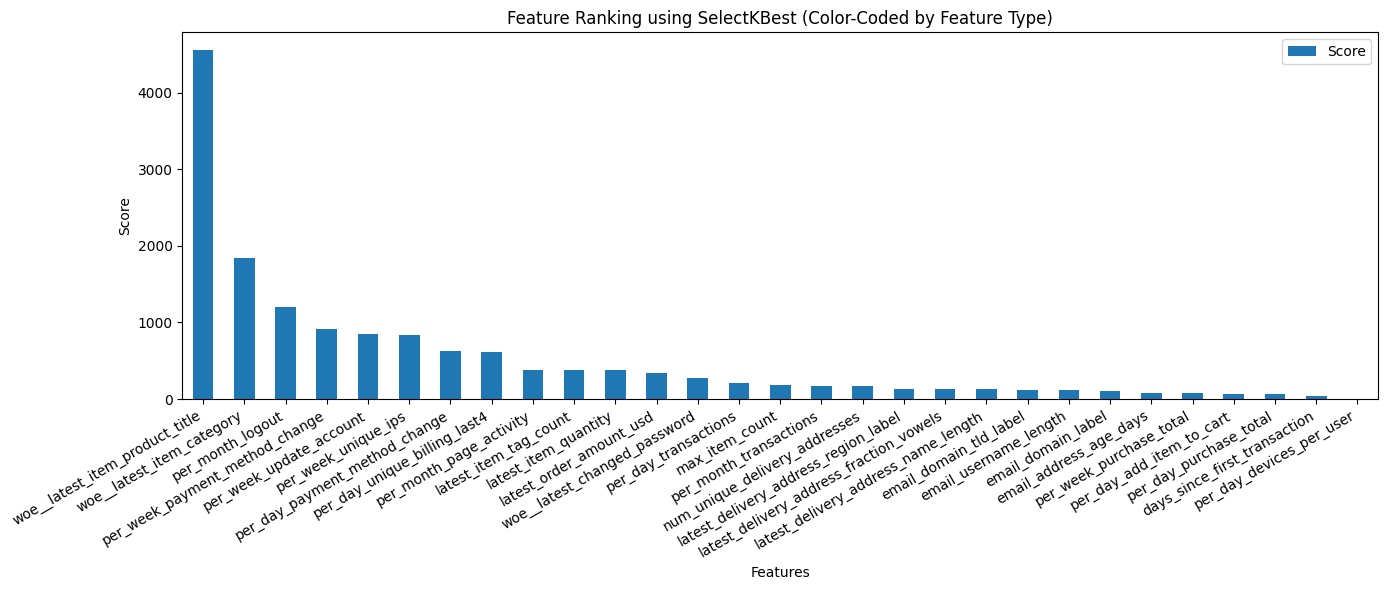

In [ ]:
# Get feature scores and p-values
feature_scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame to display feature rankings
df_feature_ranking = pd.DataFrame({'Feature': candidate_features,
                                   'Score': feature_scores,
                                   'P-value': p_values})

# Add ranking
df_feature_ranking['rank'] = df_feature_ranking['Score'].rank(ascending=False)
df_feature_ranking = df_feature_ranking.sort_values(by='Score', ascending=False).reset_index(drop=True)

# Render barplot
df_feature_ranking.plot(x='Feature', y='Score', kind='bar', figsize=(14, 6))
plt.xticks(rotation=30, ha='right')
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Feature Ranking using SelectKBest (Color-Coded by Feature Type)')
plt.tight_layout()
plt.show()

Features as `woe_latest_item_product_title` and `woe_latest_item_category` have shown to have high association in terms of predictive power in classifying fraud.

If the interpretability and mitigigation of multicollinearity would matter the most we should reduce the amount of the features as much as possible.

Our focus is to predict the power, if there's a slight presence of multicollinearity, it should be okay. In our case we have relatively small list of feature so we use them all.



## Select Features

In [ ]:
# Select top features
feats = df_feature_ranking['Feature'].tolist()
print(f'Number of features: {len(feats)}')

Number of features: 29


#Step 6 - Model Selection

We pick the champion algorithm that will power our predictions and experiment with different model architectures, train them, and assess their performance.

We follow this process:

1. **Baseline Model**: Start by establishing a baseline performance benchmark with a simple yet effective model like XGBoost. This sets a foundation to compare against when exploring more complex approaches.

2. **Hyperparameter Tuning**: Fine-tune the parameters of chosen model using techniques like grid search or random search to unlock its full potential and achieve optimal performance.

## Baseline Model

We're starting off with baseline model with already configured parameters of XGBoost classification. It's fitted on train dataset and evaluated it against the test set and validation set will be used for parameter tunning.

In [ ]:
# Initialize and train the XGBoost classifier
baseline_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=30,
    learning_rate=0.1,
    max_depth=10,
    random_state=SEED,
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='logloss'
)

baseline_model.fit(X_train[feats], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [ ]:
# Get predicted probabilities for the positive class
y_pred_train_proba = baseline_model.predict_proba(X_train[feats])[:, 1]
y_pred_test_proba = baseline_model.predict_proba(X_test[feats])[:, 1]

# Calculate ROC-AUC scores
auc_train = roc_auc_score(y_train, y_pred_train_proba)
auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Print rounded AUC scores
print("ROC-AUC Scores:")
for name, auc in zip(['Train', 'Test'], [auc_train, auc_test]):
    print(f"{name}: {auc:.4f}")

ROC-AUC Scores:
Train: 0.9998
Test: 0.9373


We have train set with 99.98% AUC score, that might be an evidence of model overfitting.

## Hyperparameter Tuning

In [ ]:
def tune_xgboost_with_undersampling(X, y, seed=123, n_iter=500):
    """
    Tunes an XGBoost classifier with RandomUnderSampler using RandomisedSearchCV.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        seed (int, optional): Random seed for reproducibility. Defaults to 123.
        n_iter (int, optional): Number of iterations for RandomisedSearchCV. Defaults to 500.

    Returns:
        RandomizedSearchCV: Fitted RandomisedSearchCV object.
    """
    np.random.seed(seed)

    # Define pipeline
    pipeline = Pipeline([
        ('sampler', RandomUnderSampler(random_state=seed)), # changes the ratio of fraud vs. non-fraud, downsampling the majority(non-fraud) class
        ('classifier', xgb.XGBClassifier(
            objective='binary:logistic',
            enable_categorical=True,
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=seed
        ))
    ])

    # Hyperparameter space
    param_dist = {
        'sampler__sampling_strategy': np.linspace(0.1, 0.8, 20), # ratio change of 10% or 80% fraud
        'classifier__n_estimators': np.arange(100, 310, 50),
        'classifier__max_depth': np.arange(10, 15),
        'classifier__learning_rate': np.linspace(0.001, 0.1, 30),
        'classifier__subsample': np.linspace(0.5, 1.0, 10),
        'classifier__colsample_bytree': np.linspace(0.5, 1.0, 10),
        'classifier__gamma': np.linspace(0, 5, 10),
        'classifier__min_child_weight': np.arange(1, 10),
        'classifier__reg_alpha': np.logspace(-4, 1, 20), # regularisation terms alpha, lambda
        'classifier__reg_lambda': np.logspace(-4, 1, 20),
    }

    # RandomisedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='roc_auc',
        cv=5,
        verbose=10,
        n_jobs=-1,
        random_state=seed
    )

    # Run randomised search
    random_search.fit(X, y)

    return random_search

### Feature Set (Top 10)
When we use top 10 feature to tweak the performance of the model the cross validation score is 98.69%

In [ ]:
# Run randomised search
random_search_top_10 = tune_xgboost_with_undersampling(X_train[feats[:10]], y_train, n_iter=100)

# Output best parameters and score
print("Best parameters found:", random_search_top_10.best_params_)
print(f"Best ROC-AUC (CV): {random_search_top_10.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'sampler__sampling_strategy': np.float64(0.1368421052631579), 'classifier__subsample': np.float64(0.5), 'classifier__reg_lambda': np.float64(0.07847599703514607), 'classifier__reg_alpha': np.float64(0.0006158482110660267), 'classifier__n_estimators': np.int64(250), 'classifier__min_child_weight': np.int64(1), 'classifier__max_depth': np.int64(14), 'classifier__learning_rate': np.float64(0.031724137931034485), 'classifier__gamma': np.float64(1.1111111111111112), 'classifier__colsample_bytree': np.float64(0.5)}
Best ROC-AUC (CV): 0.9869


### Feature Set (Top 20)

In [ ]:
# Run randomised search
random_search_top_20 = tune_xgboost_with_undersampling(X_train[feats[:20]], y_train, n_iter=100)

# Output best parameters and score
print("Best parameters found:", random_search_top_20.best_params_)
print(f"Best ROC-AUC (CV): {random_search_top_20.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'sampler__sampling_strategy': np.float64(0.1368421052631579), 'classifier__subsample': np.float64(0.5), 'classifier__reg_lambda': np.float64(0.07847599703514607), 'classifier__reg_alpha': np.float64(0.0006158482110660267), 'classifier__n_estimators': np.int64(250), 'classifier__min_child_weight': np.int64(1), 'classifier__max_depth': np.int64(14), 'classifier__learning_rate': np.float64(0.031724137931034485), 'classifier__gamma': np.float64(1.1111111111111112), 'classifier__colsample_bytree': np.float64(0.5)}
Best ROC-AUC (CV): 0.9918


### Feature Set (All)

The ROC AUC indicates that we should use all features.

In [ ]:
# Run randomized search
random_search_top_all = tune_xgboost_with_undersampling(X_train[feats], y_train, n_iter=100)

# Output best parameters and score
print("Best parameters found:", random_search_top_all.best_params_)
print(f"Best ROC-AUC (CV): {random_search_top_all.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'sampler__sampling_strategy': np.float64(0.1368421052631579), 'classifier__subsample': np.float64(0.5), 'classifier__reg_lambda': np.float64(0.07847599703514607), 'classifier__reg_alpha': np.float64(0.0006158482110660267), 'classifier__n_estimators': np.int64(250), 'classifier__min_child_weight': np.int64(1), 'classifier__max_depth': np.int64(14), 'classifier__learning_rate': np.float64(0.031724137931034485), 'classifier__gamma': np.float64(1.1111111111111112), 'classifier__colsample_bytree': np.float64(0.5)}
Best ROC-AUC (CV): 0.9958


### Deeper search on winning feature set

All the iterations before have been done with `100` potential combinations of hyperparameters that's how the RandomSearch works.

No we know that all features are the best one to go with, so we run additional iterations from `100` to `500`.

In [ ]:
# Run randomized search
random_search_top_all = tune_xgboost_with_undersampling(X_train[feats], y_train, n_iter=500)

# Output best parameters and score
print("Best parameters found:", random_search_top_all.best_params_)
print(f"Best ROC-AUC (CV): {random_search_top_all.best_score_:.4f}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters found: {'sampler__sampling_strategy': np.float64(0.1368421052631579), 'classifier__subsample': np.float64(0.5), 'classifier__reg_lambda': np.float64(0.07847599703514607), 'classifier__reg_alpha': np.float64(0.0006158482110660267), 'classifier__n_estimators': np.int64(250), 'classifier__min_child_weight': np.int64(1), 'classifier__max_depth': np.int64(14), 'classifier__learning_rate': np.float64(0.031724137931034485), 'classifier__gamma': np.float64(1.1111111111111112), 'classifier__colsample_bytree': np.float64(0.5)}
Best ROC-AUC (CV): 0.9958


We're going to plug out the winning model and evaluate it against the train, validation and test set

In [ ]:
# Access and display all parameters and scores
results = pd.DataFrame(random_search_top_all.cv_results_)
results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
77,{'sampler__sampling_strategy': 0.1368421052631...,0.995834,0.001108,1
45,{'sampler__sampling_strategy': 0.1736842105263...,0.995625,0.001140,2
349,{'sampler__sampling_strategy': 0.1368421052631...,0.995600,0.001028,3
442,"{'sampler__sampling_strategy': 0.1, 'classifie...",0.995597,0.000974,4
224,{'sampler__sampling_strategy': 0.2842105263157...,0.995436,0.001130,5
...,...,...,...,...
313,{'sampler__sampling_strategy': 0.5421052631578...,0.987763,0.001360,496
351,{'sampler__sampling_strategy': 0.4684210526315...,0.987470,0.001516,497
359,{'sampler__sampling_strategy': 0.4684210526315...,0.986821,0.001656,498
439,"{'sampler__sampling_strategy': 0.8, 'classifie...",0.986239,0.001717,499


We can see that test split is much higher than baseline test score `98.15%` vs `93.73%`

In [ ]:
# Evaluate best model on validation/test sets
best_model = random_search_top_all.best_estimator_

y_train_proba = best_model.predict_proba(X_train[feats])[:, 1]
y_valid_proba = best_model.predict_proba(X_val[feats])[:, 1]
y_test_proba = best_model.predict_proba(X_test[feats])[:, 1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_valid = roc_auc_score(y_val, y_valid_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

print("ROC-AUC Scores:")
print(f"Train AUC: {auc_train:.4f}")
print(f"Validation AUC: {auc_valid:.4f}")
print(f"Test AUC: {auc_test:.4f}")

ROC-AUC Scores:
Train AUC: 0.9990
Validation AUC: 0.9844
Test AUC: 0.9815


## Model Feature Importance

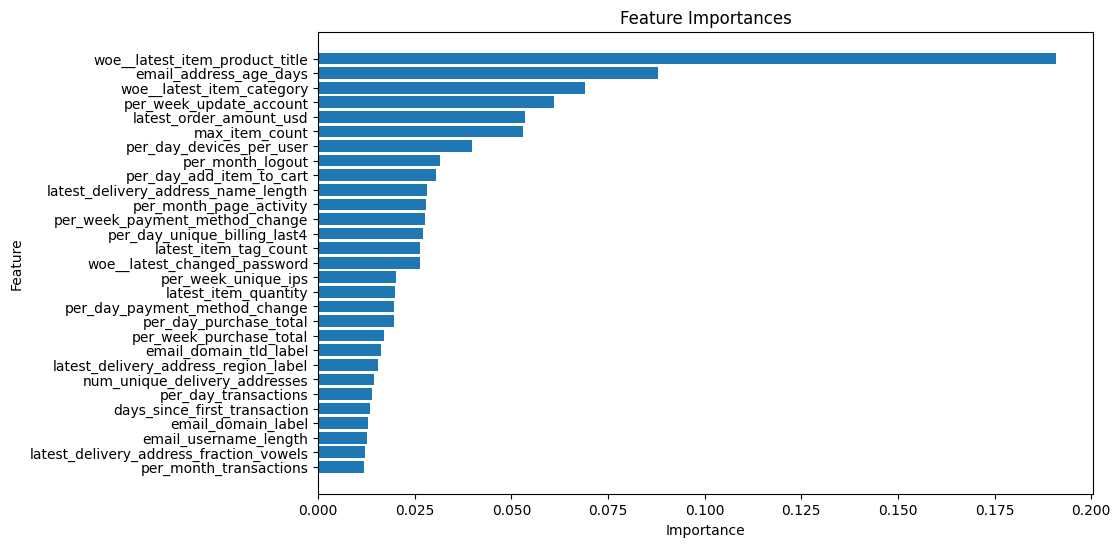

In [ ]:
# Model Feature Importance
importances = best_model.named_steps['classifier'].feature_importances_  # Access the 'classifier' step in your pipeline

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feats, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display or plot the feature importances
filter_imp = importance_df.head(30)

plt.figure(figsize=(10, 6))
plt.barh(filter_imp['Feature'], filter_imp['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

The model utilises the `woe_latest_item_product_title` a lot more in comparison to other features in terms of being able to find optimal split. We have a confidence that we have a right feature set that is going to helps us produce the right model.

#Step 7 - Evaluation

Model evaluation is where we put our model to the test and determine its true performance. It's about rigorously assessing how well our chosen model generalises to unseen data and identifying any areas for improvement.

We're going to:

1. **Precision & Recall:**  calculate the precision and recall of the model prediction across a range of fraud probability from the model. The ideal outcome would be high precision high recall.

    **Precision** - what % of customers labeled as fraud is actual fraud

    **Recall** - out of all the known fraud what % of them have we actually detected?

2. **Fraud Loss:** calculate the total $ fraud loss mitigated by the model had this been productionised

## Define Threshold

We're calculating precision and recall and doing parameters tweaks on validation set to avoid any data leakage.

As we increase the probability threshold we should see precision going up and recall is steadily going down.

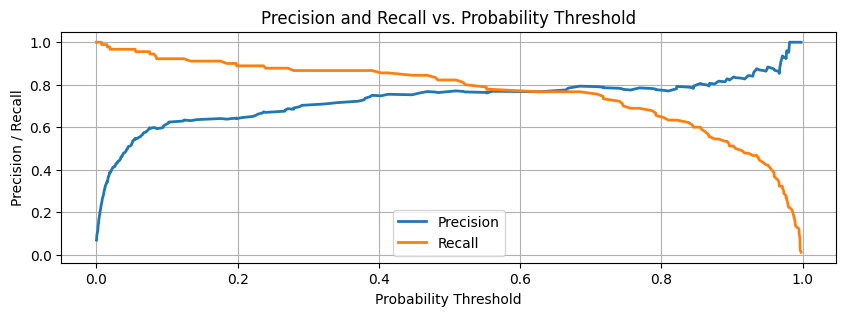

In [ ]:
# Get predicted probabilities from your best model
y_pred_proba = best_model.predict_proba(X_val[feats])[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Plot precision and recall vs. thresholds
plt.figure(figsize=(10, 3))
plt.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
plt.xlabel('Probability Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision and Recall vs. Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()

By default, scikit-learn labels anything with a predicted probability above `0.5` as fraud. However, this isn't always the best approach, since we don't know if that threshold gives us the best balance between catching fraud `(recall)` and being accurate when we flag something as fraud `(precision)`.

If our review team can handle a lot of cases, we might want to lower the threshold to catch more fraud. For example, at a threshold of `0.2`, about `60%` of the cases we flag as fraud will actually be fraud `(precision)`, and we'll catch about `90%` of all fraud cases `(recall)`.

The threshold around `0.3` seems like a good compromise: we keep a fairly high precision while still catching most fraud cases. This way, we maximise the number of frauds we catch without overwhelming the team with too many false alarms

In [ ]:
# Create a DataFrame
pr_df = pd.DataFrame({
    'threshold': np.append(thresholds, 1.0),
    'precision': precision,
    'recall': recall
})

# Inspect the DataFrame
pr_df.sort_values('threshold', ascending=False).head(50)

,threshold,precision,recall
1215,1.000000,1.000000,0.000000
1214,0.997884,1.000000,0.011111
1213,0.996703,1.000000,0.022222
1212,0.996464,1.000000,0.033333
1211,0.996393,1.000000,0.044444
1210,0.996372,1.000000,0.055556
1209,0.996361,1.000000,0.066667
1208,0.996287,1.000000,0.077778
1207,0.995591,1.000000,0.088889
1206,0.995088,1.000000,0.100000


## Confusion Matrix on Test

In [ ]:
# Generate predictions on test dataset
y_pred_proba = best_model.predict_proba(X_test[feats])[:, 1]

# Copy the test dataset to create an evaluation dataset
df_eval = X_test[feats].copy().reset_index(drop=True)

# Set threshold
threshold = 0.3

# Store the prediction
df_eval = df_eval.assign(pred_proba=y_test_proba, pred_is_fraud=(y_test_proba >= threshold).astype(int), is_fraud=y_test.values)

# Apply TP, TN, FP, FN
def apply_label(row, pred_col, label_col):
    if row[pred_col] == 1 and row[label_col] == 1:
        return 'TP'

    elif row[pred_col] == 0 and row[label_col] == 1:
        return 'FN'

    elif row[pred_col] == 1 and row[label_col] == 0:
        return 'FP'

    return 'TN'

df_eval['result'] = df_eval.apply(lambda x: apply_label(x, 'pred_is_fraud', 'is_fraud'), axis=1)

# Get percentage
pd.concat([
    df_eval['result'].value_counts(),
    df_eval['result'].value_counts(normalize=True).round(3)
], axis=1)

,count,proportion
result,,
TN,3016,0.915
TP,170,0.052
FP,81,0.025
FN,30,0.009


We have `3016` true negative cases, where the customers are not fraud and model has correctly labeled them as non-fraud, that is about `91%`. True positive cases are fraud and model has labeled them as fraud, that's about `5.2%`. The false positive cases `2.5%` those are customers that have been falsly labeled as fraud and false negative cases `0.09%` are fraudstera that have been misslabeled as non-fraud customers.

It does not give us a sense what the actual performance is in terms of monetary value.

## Calculate Fraud Loss in $

**What would be the actual savings of this model mitigating fraud cases?**

`Net Value` = `(TP * avg_spend)` + `(TN * avg_ltv)` - `(FN * avg_spend)` - `(FP * avg_ltv)`

We use `per_week_purchase_total` as proxy to say how much money would have Doordash lost because of a fraud case, it  essentially means reimbursment.

Reimbursment - if we have an account takeover and the fraudster would spend hundreds of dollar on specific items in the menu - DoorDash would have reimburse lost amount back to original user.

In [ ]:
# Calculate the average monthly spend from global data, converting weekly spend to monthly
average_spend = df_users['per_week_purchase_total'].mean() * 4
print(f'Average spend per user per month: {average_spend}')

Average spend per user per month: 187.24999593821798


In [ ]:
# If the customer's weekly spending data is missing (missing date were filled with -999) , the average spend is used to estimate the loss.
# Otherwise, the customer's weekly spend is converted to monthly spend and used as the loss. This helps to assess the potential financial impact of fraud.
df_eval['loss'] = df_eval['per_week_purchase_total'].map(lambda x: average_spend if x < 0 else x * 4)

In [ ]:
# Fraud loss calculation

# | Case | Meaning              | Cost/Benefit                         |
# |------|----------------------|--------------------------------------|
# | TP   | Fraudster caught     | ✅ Loss prevented (fraud avoided)     |
# | FP   | Good user blocked    | ❌ LTV lost (revenue sacrificed)      |
# | FN   | Fraudster missed     | ❌ Loss incurred (fraud executed)     |
# | TN   | Good user allowed    | ✅ LTV gained (revenue gained)        |

# LTV = Lifetime value of user (limited to 1 month)
# Assume LTV = spend * 25% transaction fee that DoorDash charges per every $1 spend)
#
# Formula: Net Value = (TP * avg_spend) + (TN * avg_ltv) - (FN * avg_spend) - (FP * avg_ltv)

doordash_commision = 0.25
df_eval['ltv'] = df_eval['loss'] * doordash_commision

`(TP * avg_spend)` - if we have a model that is able to correctly classify fraud, we would have prevented `$187.24` to be spent dollars on average.

`(TN * avg_ltv)` -  users who are not fraudster were able to continue to use the service and DoorDash is colleting LTV from these users.

`(FN * avg_spend)` - company is losing money, because we have fraudster users that should be fraud, but have been incorrecly classified as good and they continue to use the plaform.

`(FP * avg_ltv)` - casese where users have been good and misclassified as fraud so DoorDash is losing out from the lifetime value.

In [ ]:
# Calculate net value
def calculate_net_value(row, confusion_col, loss_col, ltv_col):
    if row[confusion_col] == 'TP':
        return row[loss_col]
    elif row[confusion_col] == 'FP':
        return -row[ltv_col]
    elif row[confusion_col] == 'FN':
        return -row[loss_col]
    else:
        return row[ltv_col]

df_eval['net_value'] = df_eval.apply(lambda x: calculate_net_value(x, confusion_col='result', loss_col='loss', ltv_col='ltv'), axis=1)

In [ ]:
# Net Value Result
print('Net Value in Total:', df_eval.net_value.sum().round(2))
df_eval.groupby('result')['net_value'].sum().round(3).apply(lambda x: '{:.2f}'.format(x))

Net Value in Total: 194175.81


,net_value
result,
FN,-10362.51
FP,-9646.61
TN,117832.69
TP,96352.25


Total Net Value = `-$10,362.51` + `(-$9,646.61)` + `$117,832.69` + `$96,352.25` = `$194,175.81`

It estimation total financial gain for DoorDash by using the model to detect and mitigate fraudulent activities. This gain is attributed to:

`Reduced fraud losses (TP)`: Preventing fraudulent transactions.

`Retained revenue (TN)`: Allowing genuine customers to continue using the platform.

`Minimized loss from incorrect classifications (FP & FN)`: While there's a small loss from blocking some genuine users (FP) and missing some fraudsters (FN), these losses are significantly outweighed by the overall benefits.

### Base Net value
The estimated financial outcome without any fraud detection model in place.

It assumes that all users are considered genuine and no fraud prevention measures are taken.

In [ ]:
# But is this better than, if the fraud detection did not exist?
df_eval['no_fraud'] = 0
df_eval['base_result'] = df_eval.apply(lambda x: apply_label(x, 'no_fraud', 'is_fraud'), axis=1)
df_eval['base_net_value'] = df_eval.apply(lambda x: calculate_net_value(x, confusion_col='base_result', loss_col='loss', ltv_col='ltv'), axis=1)

print('Net Value in Total:', df_eval.base_net_value.sum().round(2))
df_eval.groupby('base_result')['base_net_value'].sum().round(3).apply(lambda x: '{:.2f}'.format(x))

Net Value in Total: 20764.55


,base_net_value
base_result,
FN,-106714.75
TN,127479.30


The value of `$20764.55` is derived solely from the revenue generated by genuine users, minus the losses incurred due to fraud.

There's substantial positive financial impact of implementing the fraud detection model compared to a scenario without any fraud prevention measures.